**Import Libraries**

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import datetime
from datetime import date
import random


**Import Data**

In [ ]:
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [ ]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [ ]:
ts = data['2018-03-30':'2018-09-29']

In [ ]:
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
date_time,,,,,,,,,
2018-03-30 00:00:00,None,272.30,0.0,0.0,1,Clear,sky is clear,2018-03-30 00:00:00,817
2018-03-30 01:00:00,None,271.93,0.0,0.0,1,Clear,sky is clear,2018-03-30 01:00:00,413
2018-03-30 02:00:00,None,271.22,0.0,0.0,1,Clear,sky is clear,2018-03-30 02:00:00,329
2018-03-30 03:00:00,None,270.09,0.0,0.0,1,Clear,sky is clear,2018-03-30 03:00:00,359
2018-03-30 04:00:00,None,269.65,0.0,0.0,1,Clear,sky is clear,2018-03-30 04:00:00,749


Train/Test Split

In [ ]:
#Credit: Adopted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
values = pd.DataFrame(ts.traffic_volume.values).set_index(pd.DatetimeIndex(ts['date_time']))

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = pd.DataFrame(scaler.fit_transform(values)).set_index(pd.DatetimeIndex(ts['date_time']))
# frame as supervised learning
reframed = series_to_supervised(scaled, 24, 1)

In [ ]:
reframed.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
date_time,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-30 23:00:00,0.094308,0.037100,0.025205,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219
2018-03-31 00:00:00,0.037100,0.025205,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982
2018-03-31 00:00:00,0.025205,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982,0.114982
2018-03-31 01:00:00,0.029453,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982,0.114982,0.060748
2018-03-31 01:00:00,0.084679,0.313792,0.610592,0.750212,0.718777,0.681535,0.671340,0.736194,0.797508,0.770037,0.787596,0.819173,0.819173,0.847635,0.727556,0.626168,0.488955,0.436420,0.406825,0.312518,0.217219,0.114982,0.114982,0.060748,0.060748


**Train test Split**

In [ ]:
split_date = '2018-08-30'
ts_train = reframed.loc[reframed.index <= split_date].copy()
ts_test = reframed.loc[reframed.index > split_date].copy()

In [ ]:
train_values = ts_train.values
test_values = ts_test.values
# split into input and outputs
train_X, train_y = train_values[:, :-1], train_values[:, -1]
test_X, test_y = test_values[:, :-1], test_values[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(4438, 1, 24) (4438,) (968, 1, 24) (968,)


# LSTM

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

## *Vanilla LSTM*

In [ ]:
# https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recurrent-neural-network/recurrent_neural_networks
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit lstm
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Epoch 1/100
70/70 [==============================] - 33s 13ms/step - loss: 0.0972 - val_loss: 0.0296
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.0189
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0197 - val_loss: 0.0145
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0122
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0106
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 0.0123 - val_loss: 0.0094
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0074
Epoch 10/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 1

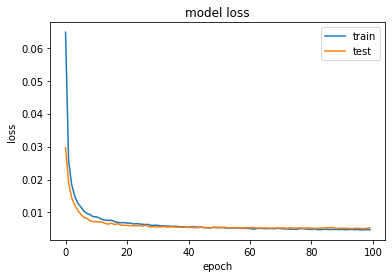

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 336.70348444797264
Train Root Mean Squared Error: 467.39245019849386
Test Mean Absolute percentage Error: 20.0167623575408
Test Mean Absolute Error: 366.76468430767375
Test Root Mean Squared Error: 515.0984048555704
Test Mean Absolute percentage Error: 22.85279365325953


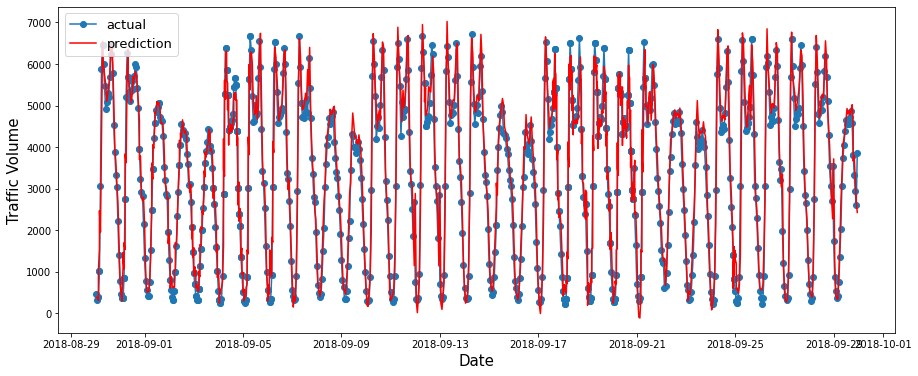

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, test_y_i[0], marker='o', label="actual")
plt.plot(ts_test.index, ts_test_fcst[:,0], 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

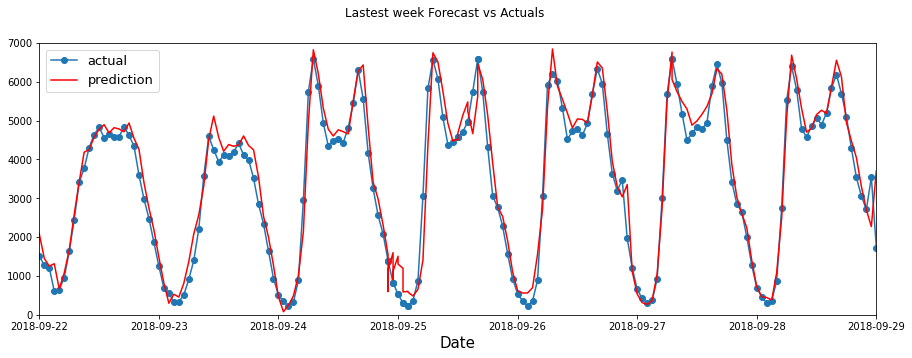

In [ ]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, test_y_i[0], marker='o', label="actual")
plt.plot(ts_test.index, ts_test_fcst[:,0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

## Stacked LSTM

In [ ]:
# https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01462-5
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Epoch 1/100
70/70 [==============================] - 3s 16ms/step - loss: 0.1336 - val_loss: 0.0287
Epoch 2/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0287 - val_loss: 0.0174
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0204 - val_loss: 0.0126
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0161 - val_loss: 0.0114
Epoch 5/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0091
Epoch 6/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0082
Epoch 7/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.0075
Epoch 8/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.0074
Epoch 9/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.0067
Epoch 10/100
70/70 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0065
Epoch 11

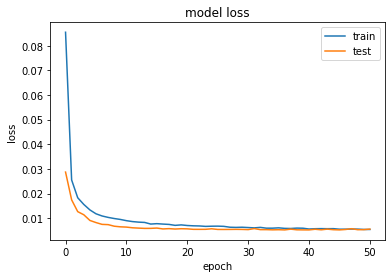

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 349.72240072115414
Train Root Mean Squared Error: 477.58112144647373
Test Mean Absolute percentage Error: 20.572905437154787
Test Mean Absolute Error: 376.8835571462458
Test Root Mean Squared Error: 526.4981797187368
Test Mean Absolute percentage Error: 22.88912917529894


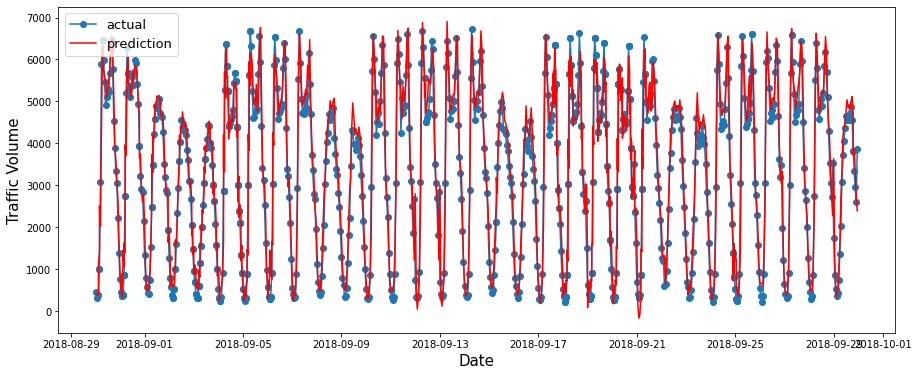

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, test_y_i[0], marker='o', label="actual")
plt.plot(ts_test.index, ts_test_fcst[:,0], 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

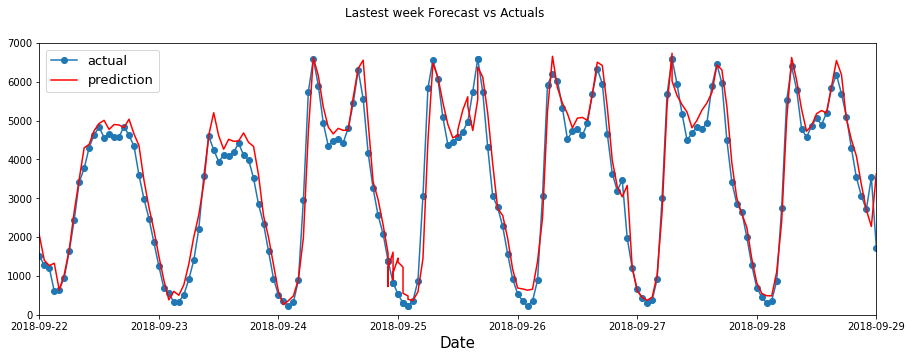

In [ ]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, test_y_i[0], marker='o', label="actual")
plt.plot(ts_test.index, ts_test_fcst[:,0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

## Bidirectional LSTM 

In [ ]:
# https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-kera
model = Sequential()
model.add(Bidirectional(LSTM(64,activation='relu',), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit LSTM
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[es])

Epoch 1/100
70/70 [==============================] - 2s 11ms/step - loss: 0.1119 - val_loss: 0.0278
Epoch 2/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0269 - val_loss: 0.0185
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.0135
Epoch 4/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0151 - val_loss: 0.0111
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 6/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0109 - val_loss: 0.0090
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 8/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0080
Epoch 9/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 10/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0086 - val_loss: 0.0068
Epoch 11

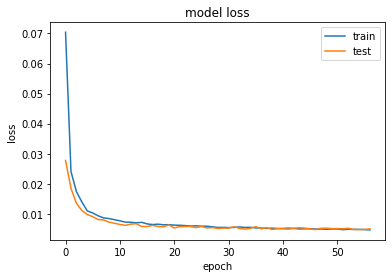

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
ts_train_fcst = model.predict(train_X)
ts_test_fcst = model.predict(test_X)
# invert predictions
ts_train_fcst = scaler.inverse_transform(ts_train_fcst)
train_y_i = scaler.inverse_transform([train_y])
ts_test_fcst = scaler.inverse_transform(ts_test_fcst)
test_y_i = scaler.inverse_transform([test_y])

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
print('Test Mean Absolute Error:', mean_absolute_error(test_y_i[0], ts_test_fcst[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(test_y_i[0], ts_test_fcst[:,0])))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(test_y_i[0], ts_test_fcst[:,0]))

Train Mean Absolute Error: 323.42600498826937
Train Root Mean Squared Error: 452.9032940745864
Test Mean Absolute percentage Error: 18.74821960941565
Test Mean Absolute Error: 353.07653792830536
Test Root Mean Squared Error: 498.5272516478108
Test Mean Absolute percentage Error: 21.072701824155597


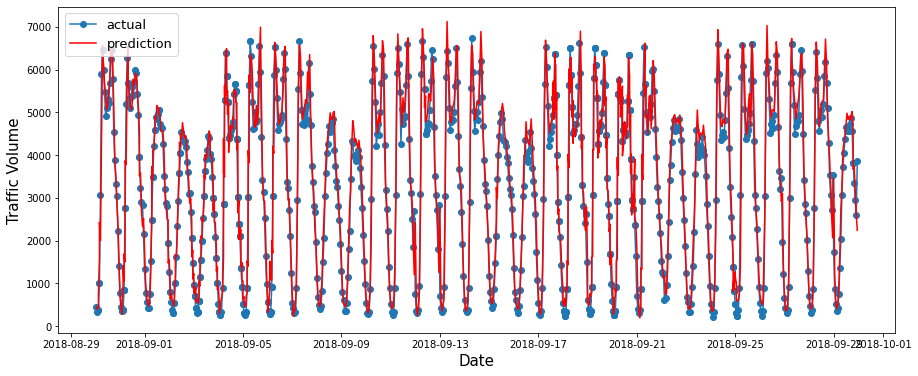

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, test_y_i[0], marker='o', label="actual")
plt.plot(ts_test.index, ts_test_fcst[:,0], 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

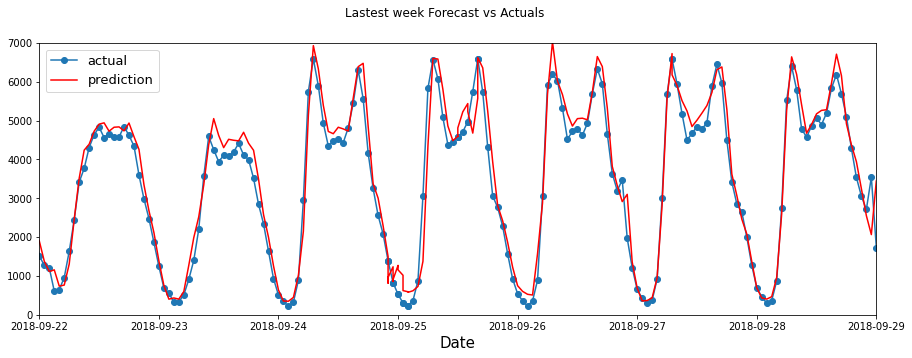

In [ ]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, test_y_i[0], marker='o', label="actual")
plt.plot(ts_test.index, ts_test_fcst[:,0], 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')